In [2]:
import scipy.io as sio

# Load your synthetic data
data = sio.loadmat(r"E:\Rutwik\Research\Hyperspectral unmixing\Project\Final Project\Datasets synthetic\5e128x128SphericGFDefaultSNR80.mat")

# Display keys to understand the structure of your .mat file
print("Data keys:", data.keys())


Data keys: dict_keys(['__header__', '__version__', '__globals__', 'abundanciesGT', 'endmembersGT', 'syntheticImageNoisy'])


In [3]:
# Extracting data
abundanciesGT = data['abundanciesGT']
endmembersGT = data['endmembersGT']
syntheticImageNoisy = data['syntheticImageNoisy']

# Print shapes to understand dimensions
print("Shape of abundanciesGT:", abundanciesGT.shape)
print("Shape of endmembersGT:", endmembersGT.shape)
print("Shape of syntheticImageNoisy:", syntheticImageNoisy.shape)


Shape of abundanciesGT: (128, 128, 5)
Shape of endmembersGT: (5, 431)
Shape of syntheticImageNoisy: (128, 128, 431)


In [64]:
import tensorflow as tf

def create_model(input_shape, num_materials, num_bands):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Initial convolutional layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Flatten the output to feed into dense layers
    flattened = tf.keras.layers.Flatten()(x)

    # Branch for abundance predictions with regularization
    abundance_branch = tf.keras.layers.Dense(
        1024, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.5)  # L2 regularization
    )(flattened)
    
    abundance_branch = tf.keras.layers.Dropout(0.5)(abundance_branch)  # Dropout for regularization
    
    abundance_branch = tf.keras.layers.Dense(128 * 128 * num_materials)(abundance_branch)
    abundance_branch = tf.keras.layers.Reshape((128, 128, num_materials))(abundance_branch)
    abundance_output = tf.keras.layers.Activation('softmax', name='abundance_output')(abundance_branch)

    # Branch for spectral signature predictions (no regularization)
    signature_branch = tf.keras.layers.Dense(num_materials * num_bands, activation='sigmoid')(flattened)
    signature_output = tf.keras.layers.Reshape((num_materials, num_bands), name='signature_output')(signature_branch)

    model = tf.keras.Model(inputs=input_layer, outputs=[abundance_output, signature_output])
    
    return model

# Define model parameters
input_shape = (128, 128, 431)
num_materials = 5
num_bands = 431

# Create the model with regularization in the abundance branch only
model = create_model(input_shape, num_materials, num_bands)

# Print model summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 431)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │    124,160 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 65536)     │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1024)      │ 67,109,888 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1024)      │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 81920)     │ 83,968,000 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 128, 128,  │          0 │ dense_13[0][0]    │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 2155)      │ 141,232,2… │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abundance_output    │ (None, 128, 128,  │          0 │ reshape_4[0][0]   │
│ (Activation)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ signature_output    │ (None, 5, 431)    │          0 │ dense_14[0][0]    │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 292,452,779 (1.09 GB)

 Trainable params: 292,452,779 (1.09 GB)

 Non-trainable params: 0 (0.00 B)

In [65]:
import tensorflow as tf
import numpy as np
import random

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [66]:
import numpy as np
# Reshape syntheticImageNoisy to include a batch dimension
X = syntheticImageNoisy[np.newaxis, ...]  # Shape becomes (1, 128, 128, 431)

# Similarly for abundanciesGT and endmembersGT
Y_abundance = abundanciesGT[np.newaxis, ...]  # Shape becomes (1, 128, 128, 5)
Y_signature = endmembersGT[np.newaxis, ...]  # Shape becomes (1, 5, 431)


In [67]:
import tensorflow as tf

# RMSE is effectively just the square root of the MSE
def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


In [68]:
def spectral_angle_mapper(y_true, y_pred):
    # Normalize true and predicted vectors
    y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)
    
    # Cosine similarity and convert to angle
    cosine_similarity = tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1)
    angle = tf.acos(tf.clip_by_value(cosine_similarity, -1.0, 1.0))
    
    return tf.reduce_mean(angle)


In [69]:
def spectral_angular_distance(y_true, y_pred):
    y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)
    
    cosine_similarity = tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1)
    distance = 1.0 - cosine_similarity  # The "angular distance" aspect
    return tf.reduce_mean(distance)


In [70]:
# Define the combined loss function
def combined_spectral_loss(y_true, y_pred):
    # Weighted combination of SAM and MSE losses
    return 0.5 * spectral_angle_mapper(y_true, y_pred) + 0.5 * rmse_loss(y_true, y_pred)

# Recompile the model with the updated loss
model.compile(
    optimizer='adam',
    loss={
        'abundance_output': rmse_loss,  # RMSE for abundance maps
        'signature_output': combined_spectral_loss  # Use the combined SAM + MSE loss for spectral signatures
    },
    metrics={
        'abundance_output': rmse_loss,
        'signature_output': [spectral_angle_mapper, rmse_loss]  # Optionally keep both SAM and RMSE as metrics for monitoring
    }
)


In [83]:
history = model.fit(
    x=X,  # Input data
    y={
        'abundance_output': Y_abundance,  # Ground truth for abundance maps
        'signature_output': Y_signature  # Ground truth for spectral signatures
    },
    #validation_split=0.2,  # Set validation data split
    epochs=250,
    batch_size=16
)


Epoch 1/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - abundance_output_loss: 0.0378 - abundance_output_rmse_loss: 0.0378 - loss: 0.2827 - signature_output_loss: 0.1389 - signature_output_rmse_loss: 0.0823 - signature_output_spectral_angle_mapper: 0.1955
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - abundance_output_loss: 0.0501 - abundance_output_rmse_loss: 0.0501 - loss: 0.2870 - signature_output_loss: 0.1390 - signature_output_rmse_loss: 0.0811 - signature_output_spectral_angle_mapper: 0.1970
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - abundance_output_loss: 0.0249 - abundance_output_rmse_loss: 0.0249 - loss: 0.2720 - signature_output_loss: 0.1416 - signature_output_rmse_loss: 0.0803 - signature_output_spectral_angle_mapper: 0.2029
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - abundance_output_loss: 0.0520 - abundance_output_rmse_loss: 0.0520 - loss: 0.2861 - signature_output_loss: 0.1343 - signature_output_rmse_loss: 0.0761 - signature_output_spectral_angle_mapper: 0.1925


In [84]:
evaluation = model.evaluate(X, {'abundance_output': Y_abundance, 'signature_output': Y_signature})
print("Evaluation results:", evaluation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - abundance_output_loss: 0.0075 - abundance_output_rmse_loss: 0.0075 - loss: 0.0435 - signature_output_loss: 0.0040 - signature_output_rmse_loss: 0.0023 - signature_output_spectral_angle_mapper: 0.0057
Evaluation results: [0.043464601039886475, 0.007484483998268843, 0.00398771557956934, 0.007484483998268843, 0.002291291020810604, 0.005684140138328075]


In [32]:
import pandas as pd
# New evaluation results provided by the user
evaluation_results_real = [0.0176088847219944, 0.007394393905997276, 0.010214490815997124, 0.007394393905997276, 0.00669839745387435, 0.01373058371245861]

# Define the corresponding metric names for real dataset evaluation
metric_names_real = ['Total Loss', 'Abundance RMSE', 'Signature SAM', 'Abundance Val RMSE', 'Signature Val SAM', 'Signature SAD']

# Create a DataFrame with the evaluation results for the real dataset
evaluation_df_real = pd.DataFrame({
    'Metric': metric_names_real,
    'Value': evaluation_results_real
})

# Display the updated DataFrame for the real dataset evaluation
evaluation_df_real


,Metric,Value
0,Total Loss,0.017609
1,Abundance RMSE,0.007394
2,Signature SAM,0.010214
3,Abundance Val RMSE,0.007394
4,Signature Val SAM,0.006698
5,Signature SAD,0.013731


In [85]:
# Get predictions from the model
predictions = model.predict(X)
predicted_abundances, predicted_signatures = predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


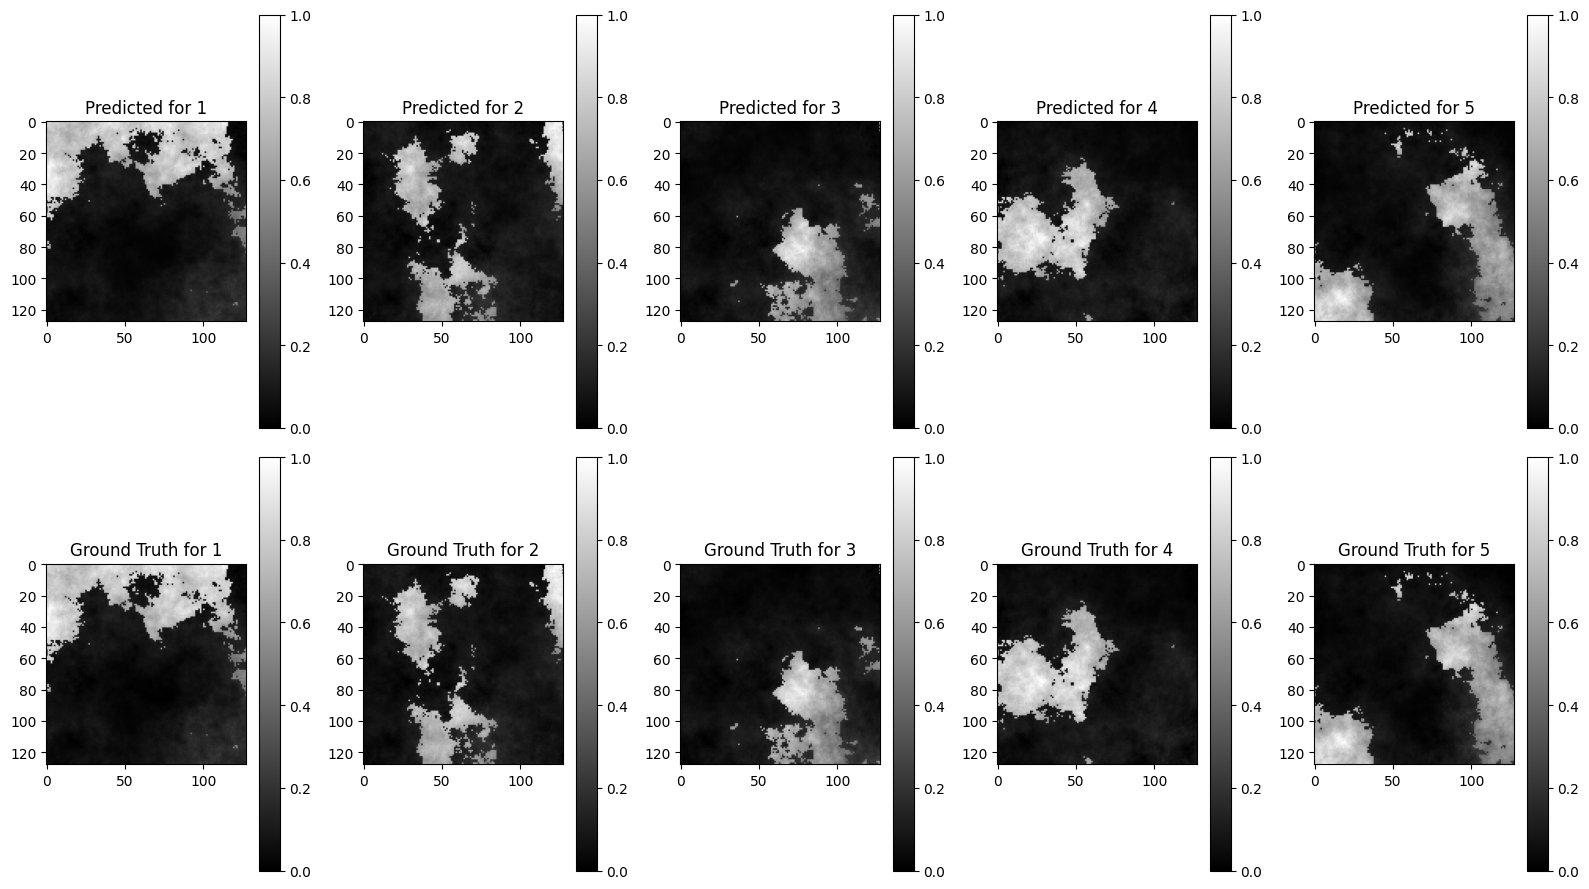

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Remove the batch dimension (1) from predictions
predicted_abundances_squeezed = np.squeeze(predicted_abundances, axis=0)
Y_abundance_squeezed = np.squeeze(Y_abundance, axis=0)

# Set up the figure and subplots for predicted and ground truth abundance maps
fig, axs = plt.subplots(2, 5, figsize=(16, 9))

# Loop over the 5 endmembers
for i in range(5):
    # Predicted abundance maps
    im_pred = axs[0, i].imshow(predicted_abundances_squeezed[:, :, i], cmap='gray', vmin=0, vmax=1)
    axs[0, i].set_title(f"Predicted for {i+1}")
    fig.colorbar(im_pred, ax=axs[0, i])

    # Ground truth abundance maps
    im_gt = axs[1, i].imshow(Y_abundance_squeezed[:, :, i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].set_title(f"Ground Truth for {i+1}")
    fig.colorbar(im_gt, ax=axs[1, i])

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [87]:
import numpy as np

# Remove the batch dimension (1) from predicted and ground truth signatures
predicted_signatures_squeezed = np.squeeze(predicted_signatures, axis=0)
Y_signature_squeezed = np.squeeze(Y_signature, axis=0)


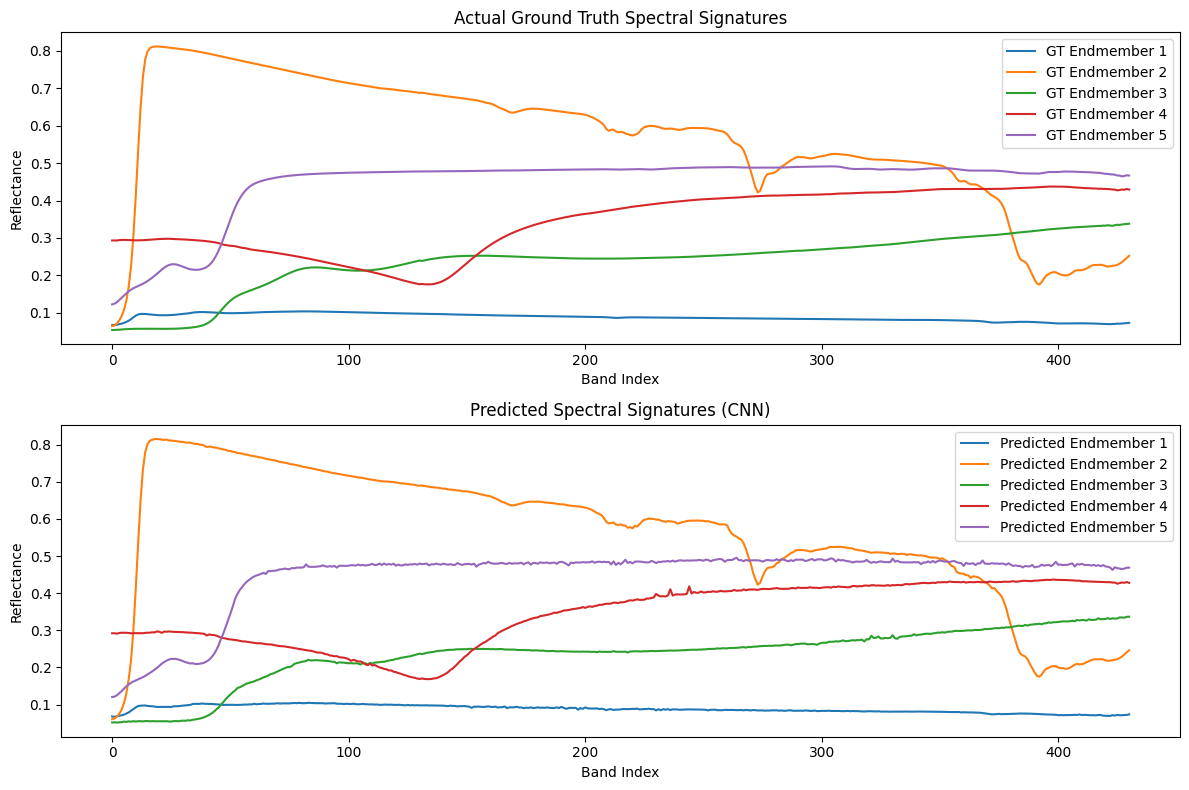

In [88]:
import matplotlib.pyplot as plt

# Plotting the spectral signatures
plt.figure(figsize=(12, 8))

# Plot ground truth spectral signatures
plt.subplot(2, 1, 1)
for i in range(5):
    plt.plot(Y_signature_squeezed[i, :], label=f"GT Endmember {i+1}")
plt.title("Actual Ground Truth Spectral Signatures")
plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.legend()

# Plot predicted spectral signatures
plt.subplot(2, 1, 2)
for i in range(5):
    plt.plot(predicted_signatures_squeezed[i, :], label=f"Predicted Endmember {i+1}")
plt.title("Predicted Spectral Signatures (CNN)")
plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.legend()

plt.tight_layout()
plt.show()
